# Model Refactoring

The mamoth AI boom in NLP puts a difficult time ahead of us where almost every now and then new paper is popping up with the SOTA crown. For a researcher, to update himself according to this super fast progress, is tremendously painful task. As a NLP enthusiast, therefore, I tried to keep the search space narrow and focus on some specific topic to dig deeper and expand the knowledge boundaries. For a learning exercise I was looking into how the seq2seq model has been evolved over time and for fun, tried to implement them in vanila Pytorch to understand the change. Because high level wrapper code like Keras, Fastai hides lot of implementation details and make it difficult to build something new from scratch. Though in this  lots of code snippets have been borrowed and tweaked to get more clarity on the implementation details. 


The prime objective is to create a smooth understanding between the research paper on specific topic, in this case seq2seq learning and it's corresponding implementation. Because only then a small tweek in the concept can be easily implemented in the code and verified as well. This is my self learning curve and I don't know which way is good, bad or ugly. So far I believe  "Understand Paper and Code Jointly" can greatly improve the overall big picture as well as the intricate implemetation details together. And this notebook is a small step towards that learning path. 

---

So the aim of this notebook is to demonstrate one such example where one seq2seq model using LSTM has been converted into seq2seq model using GRU. As already mentioned, it seems so simple at first but while doing this simple change lots of other minute factors one must remenber to correctly implement it in Pytorch.

And finally this notebook is for archiving my own experiance for future reference.

- **Paper:** Sequence to Sequence Learning with Neural Networks
  - **Author:** Ilya Sutskever, Oriol Vinyals, Quoc V. Le
  - **Paper Link**: [aRxiv](https://arxiv.org/abs/1409.3215)
  - **Published in:** NIPS 2014
- Original Implementation: [github](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

- Our Objective: To convert the notebook from LSTM implementation to GRU implementaiton and also include other debegging steps 

In [ ]:
!pip install torchviz

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot
import torch.optim as optim


from torch.autograd import Variable

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import numpy as np
import math
import os
import warnings
warnings.simplefilter('ignore')
import time

## Setting properties for plotting

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 22}	
mpl.rc('font', **font)

In [ ]:
#sorted(mpl.style.available)

## Check availability of CUDA

In [ ]:
torch.cuda.is_available()

True

## Make the model Reproducible and Deterministic

> Completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. Furthermore, results need not be reproducible between CPU and GPU executions, even when using identical seeds.

However, in order to make computations deterministic on your specific problem on one specific platform and PyTorch release, there are a couple of steps to take.

There are two pseudorandom number generators involved in PyTorch, which you will need to seed manually to make runs reproducible. Furthermore, you should ensure that all other libraries your code relies on an which use random numbers also use a fixed seed.   

_Reference:_ [pytorch_official](https://pytorch.org/docs/stable/notes/randomness.html)

In [ ]:
SEED = 2019

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# #!python -m spacy download en
!python -m spacy download de


    Linking successful
    /usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/de

    You can now load the model via spacy.load('de')



## Initial Setup

In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Checking the tokenizer

In [ ]:
sent_en = "I am Alex. I live in Berlin. !!"
sent_de = "Ich bin Alex. Ich wohne in Berlin. !!"

print(tokenize_en(sent_en))
print(tokenize_de(sent_de))

['I', 'am', 'Alex', '.', 'I', 'live', 'in', 'Berlin', '.', '!', '!']
['!', '!', '.', 'Berlin', 'in', 'wohne', 'Ich', '.', 'Alex', 'bin', 'Ich']


In [ ]:
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

## Download the dataset

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [ ]:
exam = vars(train_data.examples[0])
print("Source GERMAN (reversed): {}".format(exam['src']))
print("Target ENGLISH: {}".format(exam['trg']))

Source GERMAN (reversed): ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei']
Target ENGLISH: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [ ]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device)

## Difference between RNN, LSTM, GRU

In short below are the differences between these 3 types of module:

- $h_t=RNN(x_t, h_{t-1})$
- $h_t=GRU(x_t, h_{t-1})$
- $(h_{t-1}, c_{t-1}) =LSTM(x_t, (h_{t-1}, c_{t-1}))$

where

- x: input
- h: hidden state
- c: cell state

While building the encoder and decoder in both LSTM and GRU, put special attention to the input to the `nn.LSTM` and `nn.GRU` module and also check their output in the `Forward()`  function.

## Building the Encoder in LSTM

- the `input_dim` shouldn't be confused with the sentence length. It's the total vocabulary size. The emebedding step is to create a lookup table whose size is `vocab_size x embedding dimension`. Which, given a sentence, returns the embedding matrix of size `number of tokens in sentence x embedding dimension` for the sentence.

- always check the docstring for the different `nn.Modules`, like `nn.LSTM`, `nn.Embedding`, `nn.Dropout`. This will give clarity on how the module beahaves and what's the input, output dimension.

- the `Forward()` method is the entry point to this Encoder module, i.e whenever the EncoderLSTM() will be called it will execute the `Forward()` part.

In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell
      
class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        
        input = input.unsqueeze(0)    
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell
      
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
       
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

## Model conversion LSTM to GRU

Next we convert the `seq2seqLSTM` to `seq2seqGRU`. 

### Converting `EncoderLSTM` into `EncoderGRU`

-  the major change will be in line 13, 20 and 21 in the previous cell. In line 13, instead of nn.LSTM, we will use nn.GRU and the coresponding changes will be in the `Forward()` function as GRU doesn't have any `cell` state.

### Converting `DecoderLSTM` into `DecoderGRU`

- the major change will be in line 34, 43, 45 and the reason is same as the Encoder
- line 38: no `cell` in the  `Forward()` function call.

### Converting `Seq2SeqLSTM` into `Seq2SeqGRU`
- Here wherever the encoder or decoder is called with an input the corresponding output will change based on LSTM or GRU as the later doesn't have `cell` state. That will be in line 72, 79


In [ ]:
class EncoderGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
            
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded) # for GRU no cell state
        return hidden

class DecoderGRU(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
        
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.out(output.squeeze(0))
        return prediction, hidden
      
class Seq2SeqGRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
       
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden = self.encoder(src) # GRU encoder has no cell state
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
          
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

## Setting up hyperparameter

In [ ]:
print(TRG.vocab.itos)

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man', 'is', 'and', 'of', 'with', 'woman', ',', 'two', 'are', 'to', 'people', 'at', 'an', 'wearing', 'shirt', 'young', 'white', 'black', 'his', 'while', 'blue', 'men', 'red', 'sitting', 'girl', 'boy', 'dog', 'standing', 'playing', 'group', 'street', 'down', 'walking', '-', 'front', 'her', 'holding', 'one', 'water', 'three', 'by', 'women', 'up', 'green', 'little', 'for', 'child', 'looking', 'outside', 'as', 'large', 'through', 'brown', 'yellow', 'children', 'person', 'from', 'their', 'hat', 'ball', 'into', 'small', 'next', 'other', 'dressed', 'some', 'out', 'over', 'building', 'riding', 'running', 'near', 'jacket', 'another', 'around', 'sidewalk', 'field', 'orange', 'crowd', 'beach', 'stands', 'pink', 'sits', 'jumping', 'behind', 'table', 'snow', 'grass', 'hair', 'background', 'bike', 'stand', 'city', "'s", 'air', 'girls', 'player', 'asian', 'looks', 'wall', 'top', 'four', 'off', 'dogs', 'several', 'that', 'older', 'camer

In [ ]:
print(SRC.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fdb1d1ff048>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'kleiner': 70, 'schwarzen': 71, 'entlang': 72, 'leute': 73, 'gehen': 74, 'et

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

print("input dimension: {}".format(INPUT_DIM))
print(f'output dimension: {OUTPUT_DIM}')

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

input dimension: 7853
output dimension: 5893


**Note**: The `N_LAYERS` decides how many LSTM or GRU layer you are going to use and Pytorch will stack them by default

### Building the LSTM model

In [ ]:
?nn.CrossEntropyLoss

In [ ]:
encLSTM = EncoderLSTM(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decLSTM = DecoderLSTM(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

modelLSTM = Seq2SeqLSTM(encLSTM, decLSTM, device).to(device)

In [ ]:
optimizerLSTM = optim.Adam(modelLSTM.parameters())
pad_idx = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

### Building the GRU model

In [ ]:
encGRU = EncoderGRU(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decGRU = DecoderGRU(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

modelGRU = Seq2SeqGRU(encGRU, decGRU, device).to(device)

In [ ]:
optimizerGRU = optim.Adam(modelGRU.parameters())
pad_idx = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

## Lesson

While converting the model from LSTM to GRU, the final change will happen while declaring the `optimizer` as you need to **pass the corresponding model parameter into the optimizer**. Be very careful for this step. Otherwise your model will not learn properly and may not give any error as all the dimension is matched.

## Check if the model connection is correct

Before training the model it's better to give some dummy input to the model and run the `Forward()` step for a easy debugging of the connection setup.

### Creating dummy data

In [ ]:
# src = [src_sent_len, batch_size]

bs = 1 #batch size
src_sent_len = 12 #source sentence length
trg_sent_len = 14 #target sentence length

# creating dummy data set to test the model diension to check the network architecture

x_src = torch.LongTensor(src_sent_len, bs).random_(0, len(SRC.vocab)).to(device)
x_trg = torch.LongTensor(trg_sent_len, bs).random_(0, len(TRG.vocab)).to(device)

print(x_src.shape, x_trg.shape)

torch.Size([12, 1]) torch.Size([14, 1])


### Checking the LSTM encoder, decoder and model

In [ ]:
h, c = encLSTM(x_src)
p, h, c = decLSTM(x_trg[0,:] ,h, c)
output = modelLSTM(x_src, x_trg)
print(output.shape)

torch.Size([14, 1, 5893])


### Checking the GRU encoder, decoder and model

In [ ]:
h = encGRU(x_src)
p, h = decGRU(x_trg[0,:] ,h)
output = modelGRU(x_src, x_trg)
print(output.shape)

torch.Size([14, 1, 5893])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The LSTM model has {count_parameters(modelLSTM):,} trainable parameters')
print(f'The GRU model has {count_parameters(modelGRU):,} trainable parameters')

The LSTM model has 13,898,501 trainable parameters
The GRU model has 12,059,397 trainable parameters


In [ ]:
print(modelLSTM)

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): DecoderLSTM(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)


In [ ]:
print(modelGRU)

Seq2SeqGRU(
  (encoder): EncoderGRU(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): DecoderGRU(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)


In [ ]:
def get_num_learnable_params(array):
  
  n = len(array)
  prod = 1
  
  for i in range(n):
    prod *= array[i]
  
  return prod 

def model_summary(model, model_type):
  print("="*40+"| {} Summary |".format(model_type)+"="*40)
  ls_nop = []
  
  for name, param in model.named_parameters():
    if param.requires_grad:
      nop = get_num_learnable_params(param.data.shape)
      print("name: {} \t\t shape: {} \t\t number_of_params: {}".format(name,param.data.shape, nop))
      ls_nop.append(nop)
  
  print("total learnable params: {}".format(np.sum(ls_nop)))

In [ ]:
model_summary(modelLSTM, "modelLSTM")

========================================| modelLSTM Summary |========================================
name: encoder.embedding.weight 		 shape: torch.Size([7853, 256]) 		 number_of_params: 2010368
name: encoder.rnn.weight_ih_l0 		 shape: torch.Size([2048, 256]) 		 number_of_params: 524288
name: encoder.rnn.weight_hh_l0 		 shape: torch.Size([2048, 512]) 		 number_of_params: 1048576
name: encoder.rnn.bias_ih_l0 		 shape: torch.Size([2048]) 		 number_of_params: 2048
name: encoder.rnn.bias_hh_l0 		 shape: torch.Size([2048]) 		 number_of_params: 2048
name: encoder.rnn.weight_ih_l1 		 shape: torch.Size([2048, 512]) 		 number_of_params: 1048576
name: encoder.rnn.weight_hh_l1 		 shape: torch.Size([2048, 512]) 		 number_of_params: 1048576
name: encoder.rnn.bias_ih_l1 		 shape: torch.Size([2048]) 		 number_of_params: 2048
name: encoder.rnn.bias_hh_l1 		 shape: torch.Size([2048]) 		 number_of_params: 2048
name: decoder.embedding.weight 		 shape: torch.Size([5893, 256]) 		 number_of_params: 1508608

In [ ]:
model_summary(modelGRU, "modelGRU")

========================================| modelGRU Summary |========================================
name: encoder.embedding.weight 		 shape: torch.Size([7853, 256]) 		 number_of_params: 2010368
name: encoder.rnn.weight_ih_l0 		 shape: torch.Size([1536, 256]) 		 number_of_params: 393216
name: encoder.rnn.weight_hh_l0 		 shape: torch.Size([1536, 512]) 		 number_of_params: 786432
name: encoder.rnn.bias_ih_l0 		 shape: torch.Size([1536]) 		 number_of_params: 1536
name: encoder.rnn.bias_hh_l0 		 shape: torch.Size([1536]) 		 number_of_params: 1536
name: encoder.rnn.weight_ih_l1 		 shape: torch.Size([1536, 512]) 		 number_of_params: 786432
name: encoder.rnn.weight_hh_l1 		 shape: torch.Size([1536, 512]) 		 number_of_params: 786432
name: encoder.rnn.bias_ih_l1 		 shape: torch.Size([1536]) 		 number_of_params: 1536
name: encoder.rnn.bias_hh_l1 		 shape: torch.Size([1536]) 		 number_of_params: 1536
name: decoder.embedding.weight 		 shape: torch.Size([5893, 256]) 		 number_of_params: 1508608
nam

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)
  
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 15
CLIP = 1
SAVE_DIR = 'models'
MODEL_SAVE_PATH_LSTM = os.path.join(SAVE_DIR, 'tut1_model_lstm.pt')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

### Training Seq2SeqLSTM

In [ ]:
def train_model_utility(model, N_EPOCHS, 
                        train_iterator, valid_iterator, 
                        criterion, optimizer, CLIP, MODEL_SAVE_PATH):
  
  ls_train_loss = []
  ls_valid_loss = []

  ls_train_ppl = []
  ls_valid_ppl = []
  
  best_valid_loss = float('inf')

  for epoch in range(N_EPOCHS):

      start_time = time.time()

      train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
      valid_loss = evaluate(model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), MODEL_SAVE_PATH)

      train_loss_ppl = math.exp(train_loss)
      valid_loss_ppl = math.exp(valid_loss)

      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_loss_ppl:7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_loss_ppl:7.3f}')
    
      ls_train_loss.append(train_loss)
      ls_valid_loss.append(valid_loss)
      
      ls_train_ppl.append(train_loss_ppl)
      ls_valid_ppl.append(valid_loss_ppl)

  return ls_train_loss, ls_valid_loss, ls_train_ppl, ls_valid_ppl

In [ ]:
tl, vl, tppl, vppl = train_model_utility(modelLSTM, N_EPOCHS, train_iterator, valid_iterator, criterion, optimizerLSTM, CLIP, MODEL_SAVE_PATH_LSTM)

Epoch: 01 | Time: 1m 20s
	Train Loss: 4.990 | Train PPL: 146.931
	 Val. Loss: 4.837 |  Val. PPL: 126.090
Epoch: 02 | Time: 1m 20s
	Train Loss: 4.460 | Train PPL:  86.481
	 Val. Loss: 4.610 |  Val. PPL: 100.438
Epoch: 03 | Time: 1m 18s
	Train Loss: 4.185 | Train PPL:  65.724
	 Val. Loss: 4.422 |  Val. PPL:  83.278
Epoch: 04 | Time: 1m 18s
	Train Loss: 3.989 | Train PPL:  53.993
	 Val. Loss: 4.321 |  Val. PPL:  75.240
Epoch: 05 | Time: 1m 20s
	Train Loss: 3.799 | Train PPL:  44.673
	 Val. Loss: 4.170 |  Val. PPL:  64.741
Epoch: 06 | Time: 1m 20s
	Train Loss: 3.649 | Train PPL:  38.428
	 Val. Loss: 4.070 |  Val. PPL:  58.571
Epoch: 07 | Time: 1m 18s
	Train Loss: 3.534 | Train PPL:  34.253
	 Val. Loss: 4.002 |  Val. PPL:  54.716
Epoch: 08 | Time: 1m 18s
	Train Loss: 3.410 | Train PPL:  30.265
	 Val. Loss: 3.925 |  Val. PPL:  50.666
Epoch: 09 | Time: 1m 18s
	Train Loss: 3.309 | Train PPL:  27.353
	 Val. Loss: 3.805 |  Val. PPL:  44.932
Epoch: 10 | Time: 1m 20s
	Train Loss: 3.206 | Train PPL

In [ ]:
def plot_loss_epoch(N_EPOCHS, train_loss, valid_loss, model_type=""):
  with mpl.style.context('seaborn-notebook'):
    fig = plt.figure(figsize=(5,4))
    plt.plot(list(range(N_EPOCHS)), train_loss, color='b', alpha=0.5, label='train_loss')
    plt.plot(list(range(N_EPOCHS)), valid_loss, color='r', alpha=0.5, label='valid_loss')
    plt.title("{} Loss vs Epoch".format(model_type),fontweight="bold")
    plt.xlabel("Epoch", fontweight="bold")
    plt.ylabel("Loss", fontweight="bold")
    plt.legend()
    plt.show()

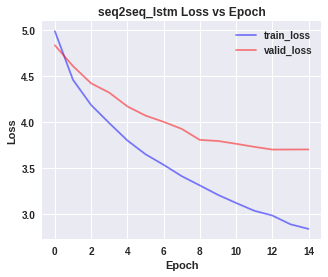

In [ ]:
plot_loss_epoch(N_EPOCHS, tl, vl, "seq2seq_lstm")

In [ ]:
def plot_ppl_epoch(N_EPOCHS, train_ppl, valid_ppl, model_type=""):
  with mpl.style.context('seaborn-notebook'):
    fig = plt.figure(figsize=(5,4))
    plt.plot(list(range(N_EPOCHS)), train_ppl, color='b', alpha=0.5, label='train_ppl')
    plt.plot(list(range(N_EPOCHS)), valid_ppl, color='r', alpha=0.5, label='valid_ppl')
    plt.title("{} PPL vs Epoch".format(model_type),fontweight="bold")
    plt.xlabel("Epoch",fontweight="bold")
    plt.ylabel("Perplexity",fontweight="bold")
    plt.legend()
    plt.show()

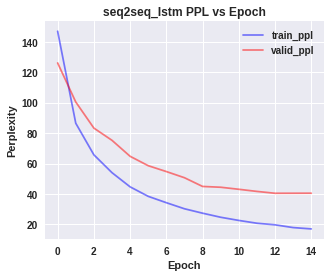

In [ ]:
plot_ppl_epoch(N_EPOCHS, tppl, vppl, "seq2seq_lstm")

In [ ]:
MODEL_SAVE_PATH_GRU = os.path.join(SAVE_DIR, 'tut1_model_gru.pt')
tl, vl, tppl, vppl = train_model_utility(modelGRU, N_EPOCHS, train_iterator, valid_iterator, criterion, optimizerGRU, CLIP, MODEL_SAVE_PATH_GRU)

Epoch: 01 | Time: 1m 13s
	Train Loss: 4.826 | Train PPL: 124.735
	 Val. Loss: 4.635 |  Val. PPL: 103.058
Epoch: 02 | Time: 1m 11s
	Train Loss: 4.035 | Train PPL:  56.519
	 Val. Loss: 4.273 |  Val. PPL:  71.730
Epoch: 03 | Time: 1m 11s
	Train Loss: 3.669 | Train PPL:  39.217
	 Val. Loss: 4.081 |  Val. PPL:  59.218
Epoch: 04 | Time: 1m 12s
	Train Loss: 3.448 | Train PPL:  31.437
	 Val. Loss: 3.934 |  Val. PPL:  51.109
Epoch: 05 | Time: 1m 13s
	Train Loss: 3.292 | Train PPL:  26.891
	 Val. Loss: 3.877 |  Val. PPL:  48.296
Epoch: 06 | Time: 1m 13s
	Train Loss: 3.165 | Train PPL:  23.691
	 Val. Loss: 3.906 |  Val. PPL:  49.688
Epoch: 07 | Time: 1m 13s
	Train Loss: 3.038 | Train PPL:  20.856
	 Val. Loss: 3.917 |  Val. PPL:  50.257
Epoch: 08 | Time: 1m 12s
	Train Loss: 2.948 | Train PPL:  19.059
	 Val. Loss: 3.812 |  Val. PPL:  45.258
Epoch: 09 | Time: 1m 13s
	Train Loss: 2.855 | Train PPL:  17.368
	 Val. Loss: 3.882 |  Val. PPL:  48.515
Epoch: 10 | Time: 1m 13s
	Train Loss: 2.787 | Train PPL

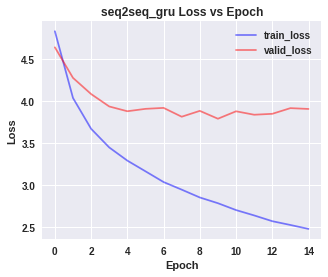

In [ ]:
plot_loss_epoch(N_EPOCHS, tl, vl, "seq2seq_gru")

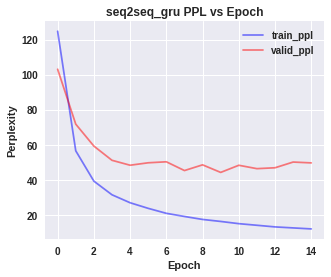

In [ ]:
plot_ppl_epoch(N_EPOCHS, tppl, vppl, "seq2seq_gru")

# Predict on the Test Dataset

implement the Prediction 

[link](https://www.guru99.com/seq2seq-model.html)


[IMP_torch_text_link](https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/)

In [ ]:
sentence = ['this','is','a','sentence']
' '.join(sentence)
#'this-is-a-sentence'

'this is a sentence'

## Get sentence from torch vector

Remember the source sentence was reversed initially. So all the tokens idx are also reversed. So while create the source sentence first reverse the source sentence vector and then apply lookup.

In [ ]:
def get_sent_trg(sent_vector_en, TRG):
  n = len(sent_vector_en)
  ls_token = []
  for i in range(n):
    ls_token.append(TRG.vocab.itos[sent_vector_en[i]])
    
  return ' '.join(ls_token)
  

def get_sent_src(sent_vector_de, SRC):
  
  n = len(sent_vector_de)
  ls_token = []
  for i in range(n):
    ls_token.append(SRC.vocab.itos[sent_vector_de[i]])
    
  return ' '.join(ls_token[::-1])

def sigmoid(preds):
  return np.argmax(1 / (1 + np.exp(-preds)), axis=1)

In [ ]:
def predict(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            
            print('+'*40)
            src = batch.src
            trg = batch.trg
            
            

            output = model(src, trg, 0) #turn off teacher forcing

            print('source.....')
            print(src.shape)
            print("source sent: >>>>>>>> {}".format(get_sent_src(src[:,0], SRC)))
            print('target.....')
            print(trg.shape)
            print("target sent: <<<<<<<< {}".format(get_sent_trg(trg[:,0], TRG)))
            print('output')
            print("predicted sent: ??????? {}".format(get_sent_trg(sigmoid(output[:,0,:].cpu()), TRG)))
            #print(trg)
            
            print(".... applying view...")
            
            
            #trg = [trg sent len, batch size]
            
            
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            
            #print('source')
            #print(src.shape)
            #print('target')
            #print(trg.shape)
            #print('output')
            #print(output.shape)
            print("==============")
            
    return

In [ ]:
#print(SRC.vocab.itos)

In [ ]:
#print(TRG.vocab.itos)

In [ ]:
test_loss = predict(modelGRU, test_iterator, criterion)

++++++++++++++++++++++++++++++++++++++++
source.....
torch.Size([10, 128])
source sent: >>>>>>>> <eos> zwei mittelgroße hunde laufen über den schnee . <sos>
target.....
torch.Size([14, 128])
target sent: <<<<<<<< <sos> two medium sized dogs run across the snow . <eos> <pad> <pad> <pad>
output
predicted sent: ??????? <unk> two brown dogs are over the mound . <eos> <eos> <eos> <eos> <eos>
.... applying view...
++++++++++++++++++++++++++++++++++++++++
source.....
torch.Size([12, 128])
source sent: >>>>>>>> <eos> eine frau verkauft auf einem gehsteig tüten mit <unk> . <sos>
target.....
torch.Size([13, 128])
target sent: <<<<<<<< <sos> woman selling bags of fruit on a sidewalk . <eos> <pad> <pad>
output
predicted sent: ??????? <unk> woman on a market with with graffiti . <eos> <eos> <eos> <eos>
.... applying view...
++++++++++++++++++++++++++++++++++++++++
source.....
torch.Size([13, 128])
source sent: >>>>>>>> <pad> <pad> <eos> ein mann im anzug sitzt an einer bushaltestelle . <sos>
target

# Predict on user input

In [ ]:
#TRG.vocab.stoi.keys()

In [ ]:
def process_sent(src_de, trg_en):
  
  ls_sos = ['<sos>']
  ls_eos = ['<eos>']
  ls_pad = ['<pad>']
  ls_unk = ['<unk>']
  
  ls_token_de = tokenize_de(source_sent_de)[::-1]
  ls_token_en = tokenize_en(target_sent_en)
  
  trg_seq = ls_sos + ls_token_en + ls_eos
  src_seq = ls_sos + ls_token_de + ls_eos + ls_pad
  
  trg_seq_idx = []
  for i in trg_seq:
    if i in TRG.vocab.stoi.keys():
      trg_seq_idx.append(TRG.vocab.stoi[i])
    else:
      trg_seq_idx.append(TRG.vocab.stoi['<unk>'])
      
  src_seq_idx = []
  for i in src_seq:
    if i in SRC.vocab.stoi.keys():
      src_seq_idx.append(SRC.vocab.stoi[i])
    else:
      src_seq_idx.append(SRC.vocab.stoi['<unk>'])
      
  print(trg_seq)
  print(trg_seq_idx)
  print()
  print(src_seq)
  print(src_seq_idx)
  
  assert len(trg_seq) == len(src_seq)
  
  return src_seq_idx[::-1], trg_seq_idx

In [ ]:
target_sent_en = "the boy is playing on the ground"
source_sent_de = "der junge spielt auf dem boden"

In [ ]:
src_idx, trg_idx = process_sent(source_sent_de, target_sent_en)

['<sos>', 'the', 'boy', 'is', 'playing', 'on', 'the', 'ground', '<eos>']
[2, 7, 34, 10, 37, 8, 7, 185, 3]

['<sos>', 'der', 'junge', 'spielt', 'auf', 'dem', 'boden', '<eos>', '<pad>']
[2, 15, 26, 38, 12, 24, 122, 3, 1]


In [ ]:
src_idx_np_ar = np.array(src_idx)
src_idx_tensor = Variable(torch.from_numpy(src_idx_np_ar)).type(torch.LongTensor).to(device)
src_idx_tensor = src_idx_tensor.view(-1, 1)


trg_idx_np_ar = np.array(trg_idx)
trg_idx_tensor = torch.from_numpy(trg_idx_np_ar).type(torch.LongTensor).to(device)
trg_idx_tensor = trg_idx_tensor.view(-1, 1)

In [ ]:
#src_idx_tensor, src_idx_tensor.shape

In [ ]:
#trg_idx_tensor, trg_idx_tensor.shape

In [ ]:
output = modelLSTM(src_idx_tensor, trg_idx_tensor, 0) #turn off teacher forcing

print('source.....')
print(src_idx_tensor.shape)
print("source sent: >>>>>>>> {}".format(get_sent_src(src_idx_tensor[:,0], SRC)))
print('target.....')
print(trg_idx_tensor.shape)
print("target sent: <<<<<<<< {}".format(get_sent_trg(trg_idx_tensor[:,0], TRG)))
print('output')
print(output.shape)
print("predicted sent: ??????? {}".format(get_sent_trg(sigmoid(output[:,0,:].cpu().detach().numpy()), TRG)))

source.....
torch.Size([9, 1])
source sent: >>>>>>>> <sos> der junge spielt auf dem boden <eos> <pad>
target.....
torch.Size([9, 1])
target sent: <<<<<<<< <sos> the boy is playing on the ground <eos>
output
torch.Size([9, 1, 5893])
predicted sent: ??????? <unk> the boy is playing the beach with the
